# Uçtan Büyük Veride Makine Öğrenmesi

## 1.Spark Session ve Veri Seti

In [2]:
import findspark
findspark.init("C:\spark")

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("churn_modellemesi") \
    .config("spark.executer.memory", "16gb") \
    .getOrCreate()



sc = spark.sparkContext
sc

<SparkContext master=local appName=churn_modellemesi>

In [4]:
spark_df=spark.read.csv("churn.csv",
                       header=True,
                       inferSchema=True,
                       sep=",")
spark_df.cache()

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [5]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [6]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [7]:
#tablodaki bütün degişkenlerin isimlerini küçük harfe çevirme işlemi yapalım
spark_df=spark_df.toDF(*[c.lower() for c in spark_df.columns])

In [8]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           names| age|total_purchase|account_manager|years|num_sites|churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



#df.columns=map(str.lower,df.columns)=>pandas dataFrame de isim degişikligi yapmak istersek 

#isimlemdirmede camel tarz yazım iki kelime bitişik ve ikinici kelime büyük harfle yazılır 

In [14]:
#_co ismini degiştirme yapmak için(index yaptık ismi)
spark_df=spark_df.withColumnRenamed("_c0","index")

In [13]:
spark_df.show(2)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 2 rows



In [16]:
spark_df.count()#gözlem sayısı

900

In [19]:
spark_df.columns#degişken isimlerine erişmek istersek

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn']

In [21]:
len(spark_df.columns)#degişken sayısını bize verir

8

In [23]:
#veri setinde eşsiz deger var mı yok mu kontrol edelim
spark_df.distinct().count()#çıkan sonuc 900 yani gözlem sayısı ile eşit yani gözlemlerin hepsi unique

900

In [25]:
spark_df.select("names").distinct().count()#burada isimlerde unique olan varmı baktık,1 tanesi öyle degilmiş

899

In [27]:
#bu çıkan sonuç şimdi degerler çoklamamı yoksa aynı isimden 2 tane mi var onu kontrol edelim
spark_df.groupby("names").count().sort("count",ascending=False).show(3)

+-------------+-----+
|        names|count|
+-------------+-----+
|Jennifer Wood|    2|
| Patrick Bell|    1|
|Chelsea Marsh|    1|
+-------------+-----+
only showing top 3 rows



#şimdi burada jennifer 2 kere var,peki bu çoklamamı yoksa aynı gözlem birimi mi?

#jennifere erişelim sonra inceleme için

In [30]:
spark_df.filter(spark_df.names=="Jennifer Wood").show()

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



buradan onun bir çoklama olmadıgını anlamış olduk 

#Çoklama kayıtlarını silmek istersek eger 

In [34]:
spark_df.select("names").dropDuplicates().groupBy("names").count().sort("count",ascending=False).show(3)
#silme gerçekleşti ve duplicate kayıttan kurtulmuş olduk 

+----------------+-----+
|           names|count|
+----------------+-----+
|    Patrick Bell|    1|
|Patrick Robinson|    1|
|   Chelsea Marsh|    1|
+----------------+-----+
only showing top 3 rows



In [37]:
#herhangi bir index'e erişmek istersek eger
spark_df.where(spark_df.index==439).select("names").show()#439'uncu indexe erişmiş olduk 

+-------------+
|        names|
+-------------+
|Jennifer Wood|
+-------------+



In [39]:
spark_df.where(spark_df.index==439).show()#439 unucu index'in tamamına erişmiş olduk 

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [43]:
#şimdi yapacagımız işlem şu Jenniferi saklayıp onu girdi olarak kullanmak
#CİDDİ BİR PROBLEMDİR
#collect kullanarak,veriyi kullanabilir hale getirdik

In [44]:
spark_df.where(spark_df.index==439).collect()[0]["names"]#çıkan sonuçu str şeklinde elde ettik

'Jennifer Wood'

In [45]:
jen=spark_df.where(spark_df.index==439).collect()[0]["names"]

In [46]:
type(jen)

str

In [47]:
dir(jen)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


In [49]:
jen.upper()#local python fonksiyonlarını kullanrak degişiklikler yapabiliriz

'JENNIFER WOOD'

# Keşifçi Veri Analizi

In [50]:
spark_df.describe().show()

+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|             index|        names|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               900|          900|              900|              900|               900|              900|               900|                900|
|   mean|             449.5|         null|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|259.95191863111916|         null|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|                 0|   Aaron King|             22.0|          

#eger tablonun görüntüsünü düzeltmek istersek 

ya print parantezi içine alırız

ya da sadece işimizi olanları seçme işlemine alıp yaparız 

In [53]:
spark_df.select("age","total_purchase","account_manager","years","num_sites","churn").describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


In [54]:
spark_df.filter(spark_df.age>47).count()

161

In [55]:
spark_df.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [57]:
#bazı çaparazlama işlemleri yapmak istersek
spark_df.groupby("churn").agg({"total_purchase":"mean"}).show()

+-----+-------------------+
|churn|avg(total_purchase)|
+-----+-------------------+
|    1| 10192.179933333337|
|    0| 10036.952853333332|
+-----+-------------------+



In [58]:
#korelasyon oluşturmak istersek
kor_data=spark_df.drop("index","names","churn").toPandas()

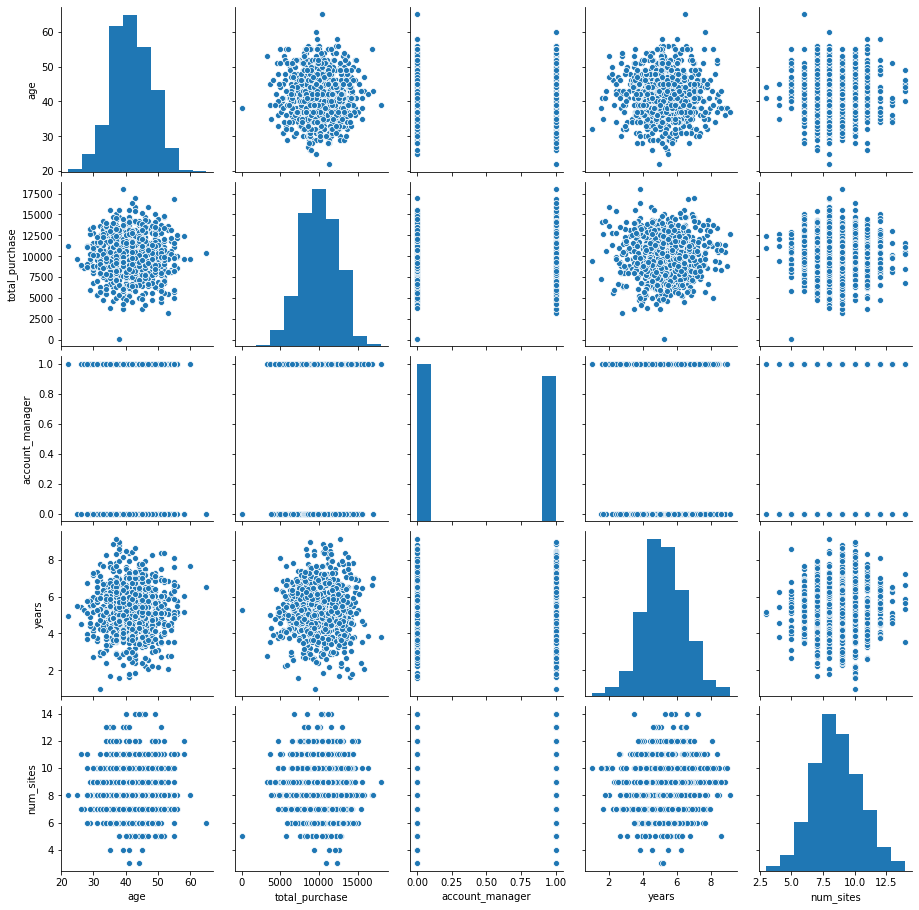

In [59]:
import seaborn as sns 
sns.pairplot(kor_data);

In [63]:
kor_data=spark_df.drop("index","names").toPandas()

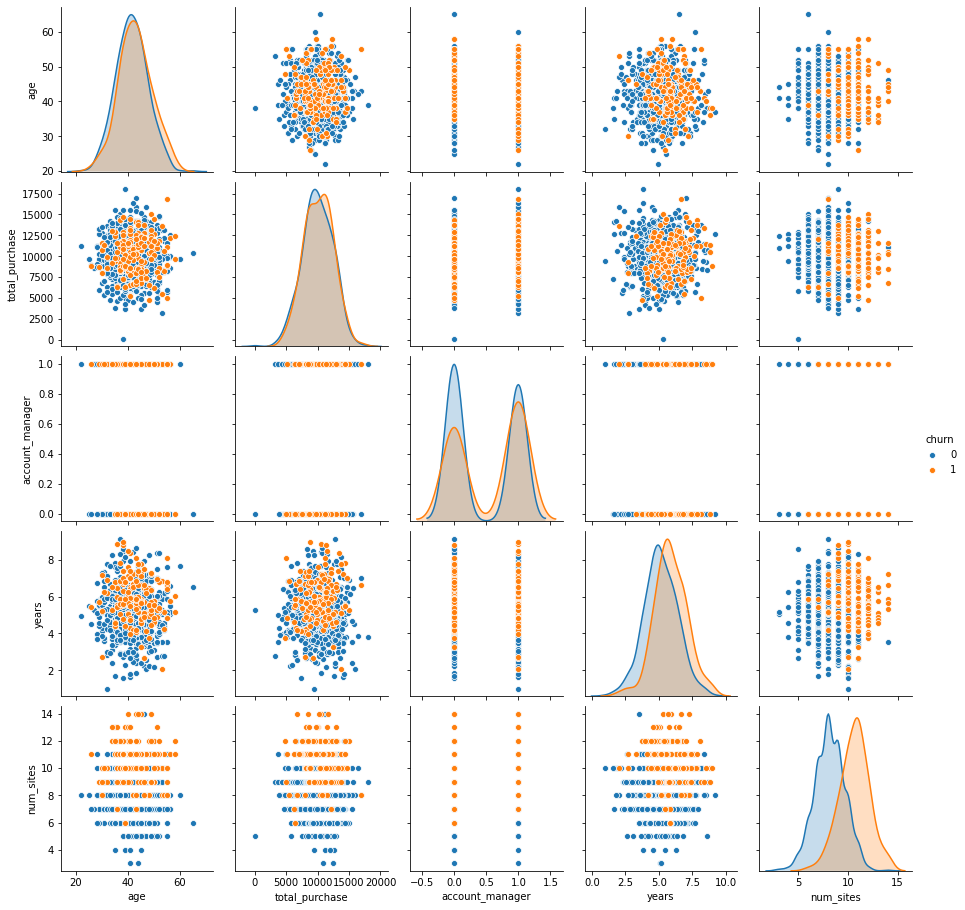

In [65]:
#churn bir boyut olarak eklemek istersek
import seaborn as sns
sns.pairplot(kor_data, hue = "churn");

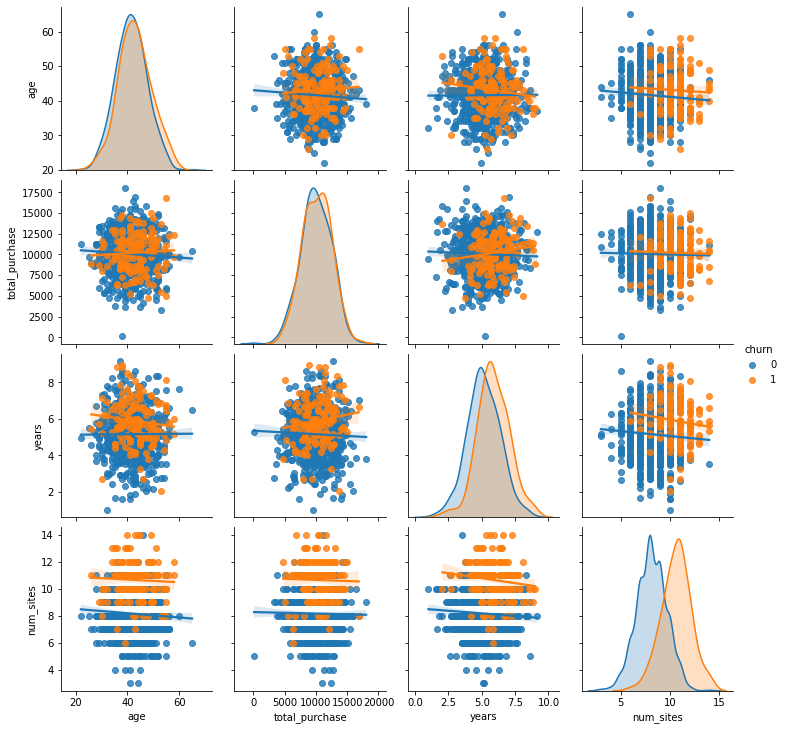

In [68]:
#bagımlı degişkeni korelasyon maddesi olmadan bir boyut olarak eklemek amacımız,yukarıda ayırt ediciligi gördük fakat grafik biraz iyi olmadı 
#var'a anlamı kabul ettigimiz degişkenleri yazalım
#regresyon egrilerini ise kind ile yaparız
sns.pairplot(kor_data,vars=["age","total_purchase","years","num_sites"] ,
             hue="churn",
             kind="reg");

# Veri Ön İşleme

In [69]:
#eksik gözlemlerden kurtulma işlemi yapıcaz
spark_df=spark_df.dropna()

In [70]:
spark_df=spark_df.withColumn("age_kare",spark_df.age**2)

In [71]:
spark_df.show(3)

+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|age_kare|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|  1764.0|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|  1681.0|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|  1444.0|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
only showing top 3 rows



In [72]:
from pyspark.ml.feature import StringIndexer
#bagımsız degişkenlere future,bagımlı degişkenlere label 

stringIndexer=StringIndexer(inputCol="churn",outputCol="label")

In [74]:
?stringIndexer

Type:           StringIndexer
String form:    StringIndexer_2b7bf384af00
File:           c:\spark\python\pyspark\ml\feature.py
Docstring:     
A label indexer that maps a string column of labels to an ML column of label indices.
If the input column is numeric, we cast it to string and index the string values.
The indices are in [0, numLabels). By default, this is ordered by label frequencies
so the most frequent label gets index 0. The ordering behavior is controlled by
setting :py:attr:`stringOrderType`. Its default value is 'frequencyDesc'.

.. versionadded:: 1.4.0

Examples
--------
>>> stringIndexer = StringIndexer(inputCol="label", outputCol="indexed",
...     stringOrderType="frequencyDesc")
>>> stringIndexer.setHandleInvalid("error")
StringIndexer...
>>> model = stringIndexer.fit(stringIndDf)
>>> model.setHandleInvalid("error")
StringIndexerModel...
>>> td = model.transform(stringIndDf)
>>> sorted(set([(i[0], i[1]) for i in td.select(td.id, td.indexed).collect()]),
...     key=l

In [78]:
indexed=stringIndexer.fit(spark_df).transform(spark_df)

In [79]:
indexed.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_kare', 'double'),
 ('label', 'double')]

In [80]:
spark_df=indexed.withColumn("label",indexed["label"].cast("integer"))

In [81]:
spark_df.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_kare', 'double'),
 ('label', 'int')]

In [87]:
#bagımsız degişkenlerin ayaralanması,onları vektor oluşturma işlemi yapıyoruz

In [84]:
from pyspark.ml.feature import VectorAssembler

In [85]:
spark_df.columns

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn',
 'age_kare',
 'label']

In [95]:
bag=["age","total_purchase","account_manager","years","num_sites"]

In [96]:
vectorAssembler=VectorAssembler(inputCols=bag,outputCol="features")

In [97]:
va_df=vectorAssembler.transform(spark_df)

In [98]:
#final df imisi oluşturalım bagımlı ve bagımsızlar bir arada olacak 

In [99]:
final_df=va_df.select(["features","label"])

In [100]:
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



## Test-Train

In [101]:
splits=final_df.randomSplit([0.7,0.3])
train_df=splits[0]
test_df=splits[1]

In [102]:
train_df

DataFrame[features: vector, label: int]

In [103]:
test_df

DataFrame[features: vector, label: int]

# GBM ile Müşteri Terk Modellemesi

In [104]:
from pyspark.ml.classification import GBTClassifier

In [106]:
gbm=GBTClassifier(maxIter=10,featuresCol="features",labelCol="label")#model nesnesi oluşturduk 

In [107]:
#model fit etme işlemi 
gbm_model=gbm.fit(train_df)

In [108]:
y_pred=gbm_model.transform(test_df)

In [109]:
ac=y_pred.select("label","prediction")

In [111]:
ac.filter(ac.label==ac.prediction).count()/ac.count()#valide edilmemiş test hatası

0.8339483394833949

In [112]:
#model tuning işlemi yapmak için

In [114]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()#degerlendirme yöntemini olarak nesne oluşturduk 

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())#parametre girdilerimi oluşturduk

cv = CrossValidator(estimator= gbm, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds= 10)
#model nesnelerini oluşturduk ve 10 katlı olacak

In [ ]:
cv_model=cv.fit(train_df)

In [ ]:
y_pred=cv_model.transform(test_df)
ac=y_pred.select("label","prediction")

In [117]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

0.8892988929889298

In [118]:
#egri altında kalan alana erişmek istersek 
evaluator.evaluate(y_pred)

0.8851127320954908

## Bu müşteriler bizi terk eder mi?

In [119]:
import pandas as pd
names = pd.Series(["Ali Ahmetoğlu", "Berkcan Tanerbey", "Harika Gündüz","Polat Alemdar", "Ata Bakmayan Ali"])
age = pd.Series([38, 43, 34, 50, 40])
total_purchase = pd.Series([30000, 10000, 6000, 30000, 100000])
account_manager = pd.Series([1,0,0,1,1])
years = pd.Series([20, 10, 3, 8, 30])
num_sites = pd.Series([30,8,8,6,50])


yeni_musteriler = pd.DataFrame({
    'names':names,
    'age': age,
    'total_purchase': total_purchase,
    'account_manager': account_manager ,
    'years': years,
    'num_sites': num_sites})

yeni_musteriler.columns

Index(['names', 'age', 'total_purchase', 'account_manager', 'years',
       'num_sites'],
      dtype='object')

In [120]:
yeni_musteriler

,names,age,total_purchase,account_manager,years,num_sites
0,Ali Ahmetoğlu,38,30000,1,20,30
1,Berkcan Tanerbey,43,10000,0,10,8
2,Harika Gündüz,34,6000,0,3,8
3,Polat Alemdar,50,30000,1,8,6
4,Ata Bakmayan Ali,40,100000,1,30,50


In [121]:
yeni_sdf = spark.createDataFrame(yeni_musteriler)

In [122]:
type(yeni_sdf)

pyspark.sql.dataframe.DataFrame

In [123]:
yeni_sdf.show()

+----------------+---+--------------+---------------+-----+---------+
|           names|age|total_purchase|account_manager|years|num_sites|
+----------------+---+--------------+---------------+-----+---------+
|   Ali Ahmetoğlu| 38|         30000|              1|   20|       30|
|Berkcan Tanerbey| 43|         10000|              0|   10|        8|
|   Harika Gündüz| 34|          6000|              0|    3|        8|
|   Polat Alemdar| 50|         30000|              1|    8|        6|
|Ata Bakmayan Ali| 40|        100000|              1|   30|       50|
+----------------+---+--------------+---------------+-----+---------+



In [124]:
yeni_musteriler = vectorAssembler.transform(yeni_sdf)

In [125]:
sonuclar = cv_model.transform(yeni_musteriler)

In [126]:
sonuclar.select("names","prediction").show()

+----------------+----------+
|           names|prediction|
+----------------+----------+
|   Ali Ahmetoğlu|       1.0|
|Berkcan Tanerbey|       0.0|
|   Harika Gündüz|       0.0|
|   Polat Alemdar|       0.0|
|Ata Bakmayan Ali|       1.0|
+----------------+----------+



#ali ve ata churn olacak

## Diğer Bazı Modeller

In [ ]:
from pyspark.ml.classification import LogisticRegression
loj = LogisticRegression(featuresCol = "features", labelCol = 'label', maxIter=10)
loj_model = loj.fit(train_df)
y_pred = loj_model.transform(test_df)
ac = y_pred.select("label", "prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dt_model = dt.fit(train_df)
y_pred = dt_model.transform(test_df)
ac = y_pred.select("label", "prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train_df)
y_pred = rf_model.transform(test_df)
ac = y_pred.select("label", "prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()